In [75]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"
import matplotlib
from matplotlib import rcParams, colors
import matplotlib.pyplot as plt
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 14

from tqdm import tqdm
import torch
import numpy as np
import joblib

import sys
sys.path.append("/home/jdli/transpec")
from kvxp.kvxp import xp2label
from astroquery.gaia import Gaia
from tqdm import tqdm
import pandas as pd
from astropy.table import Table
import time

In [70]:
data_dir = "/data/jdli/gaia/"

cat_name = "gdr3_prlx_frac.fits.gz"
cat = Table.read(data_dir+cat_name).to_pandas()

print(cat.shape, cat.columns)

(737640, 34) Index(['source_id', 'ra', 'dec', 'l', 'b', 'ecl_lon', 'ecl_lat', 'parallax',
       'parallax_error', 'parallax_over_error', 'pmra', 'pmdec',
       'astrometric_params_solved', 'astrometric_primary_flag',
       'nu_eff_used_in_astrometry', 'pseudocolour', 'phot_g_mean_flux',
       'phot_g_mean_flux_error', 'phot_g_mean_flux_over_error',
       'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'bp_rp',
       'radial_velocity', 'radial_velocity_error',
       'astrophysical_parameters_teff_gspphot',
       'astrophysical_parameters_logg_gspphot',
       'astrophysical_parameters_mh_gspphot',
       'astrophysical_parameters_distance_gspphot',
       'astrophysical_parameters_distance_gspphot_lower',
       'astrophysical_parameters_distance_gspphot_upper',
       'astrophysical_parameters_azero_gspphot',
       'astrophysical_parameters_ag_gspphot',
       'astrophysical_parameters_arp_gspphot'],
      dtype='object')


In [71]:
nfs_dir = "/nfsdata/share/gaiaxp/"

all_xp = pd.read_csv(nfs_dir+"gdr3_jdli_sid_xp_continuous_mean_spectrum.csv", sep='|', 
                         chunksize=100000)


xp_tr = pd.DataFrame()


for chunk in tqdm(all_xp):
    
    result_temp = pd.merge(chunk, cat, on='source_id')
    xp_tr = pd.concat([xp_tr, result_temp], ignore_index=True)



169it [10:06,  3.59s/it]


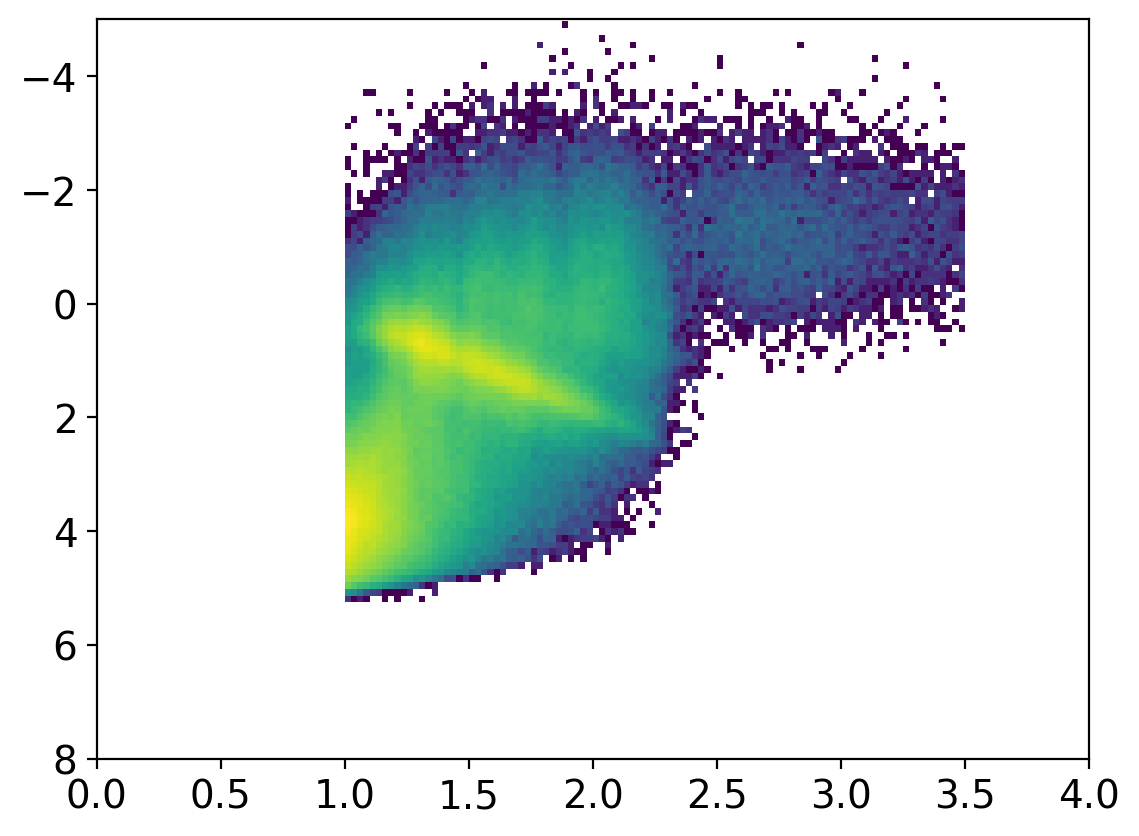

In [76]:
def abs_mag(prlx, mag):
    # m - 5*np.log10(1000/prlx) + 5
    return mag + 5*np.log10(prlx/100) 


plt.hist2d(xp_tr['bp_rp'], abs_mag(xp_tr['parallax'], xp_tr['phot_g_mean_mag']), 
           bins=100, norm=colors.LogNorm())

plt.xlim([0, 4]);
plt.ylim([8, -5]);

# Data reduction

In [77]:
import ast

bp_coef = np.array([ast.literal_eval(bp) for bp in xp_tr['bp_coefficients'].values])
rp_coef = np.array([ast.literal_eval(bp) for bp in xp_tr['bp_coefficients'].values])

xp_coef = np.hstack((bp_coef, rp_coef))
print(xp_coef.shape)

(725792, 110)


In [78]:
from sklearn import preprocessing
import joblib


scaler_xp = preprocessing.RobustScaler(quantile_range=(2.5, 97.5))
norm_xp = scaler_xp.fit_transform(xp_coef)

joblib.dump(scaler_xp, '../models/scaler_xp.gz')


['../models/scaler_xp.gz']

In [116]:
from zero_point import zpt
zpt.load_tables()

gmag = xp_tr['phot_g_mean_mag'].values
nueffused = xp_tr['nu_eff_used_in_astrometry'].values
psc = xp_tr['pseudocolour'].values
ecl_lat = xp_tr['ecl_lat'].values
soltype = xp_tr['astrometric_params_solved'].values

zpvals = zpt.get_zpt(gmag, nueffused, psc, ecl_lat, soltype) 


/data/jdli/anaconda3/envs/gaia/lib/python3.9/site-packages/zero_point/zpt.py:233: UserWarning: The pseudocolour of some of the 6p source(s) is outside the expected range (1.24-1.72 mag).
                 The maximum corrections are reached already at 1.24 and 1.72
  warnings.warn(


In [117]:
def inflat_sigma_prlx(gmag, e_prlx):
    """El-Badry et al. 2021, Eq. 16
    """
    inflat = 0.21 * np.exp(-(gmag-12.65)**2/0.9**2) +\
             1.141 + 0.004*gmag - 0.00062*gmag**2
    
    return e_prlx * inflat


def pseudo_lum(parallax, mag, a_mag, zp):
    return (parallax-zp) * np.power(10, 0.2*(mag-a_mag))


def pseudo_elum(e_parallax, mag, a_mag):
    return e_parallax * np.power(10, 0.2*(mag-a_mag))



lum_pseu = pseudo_lum(xp_tr['parallax'], xp_tr['phot_g_mean_mag'], 
                      xp_tr['astrophysical_parameters_ag_gspphot'], zpvals)

e_prlx = inflat_sigma_prlx(xp_tr['phot_g_mean_mag'], xp_tr['parallax_error'])
elum_pseu = pseudo_elum(e_prlx, xp_tr['phot_g_mean_mag'], xp_tr['astrophysical_parameters_ag_gspphot'])
    

In [158]:
xp_tr = xp_tr.assign(
    e_prlx_crct=e_prlx, lum_pseu=lum_pseu, e_lum_pseu=elum_pseu
)

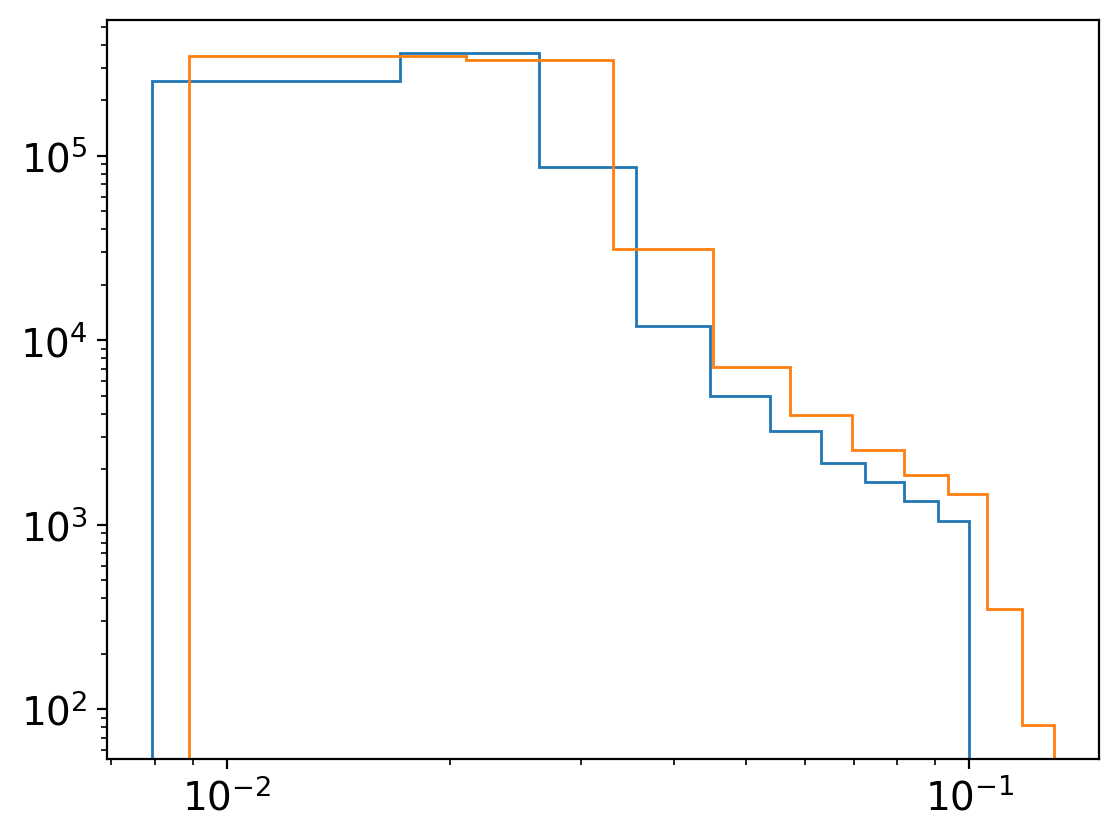

In [118]:
plt.hist(xp_tr['parallax_error'], histtype='step');
plt.hist(e_prlx, histtype='step');
plt.xscale('log')
plt.yscale('log')


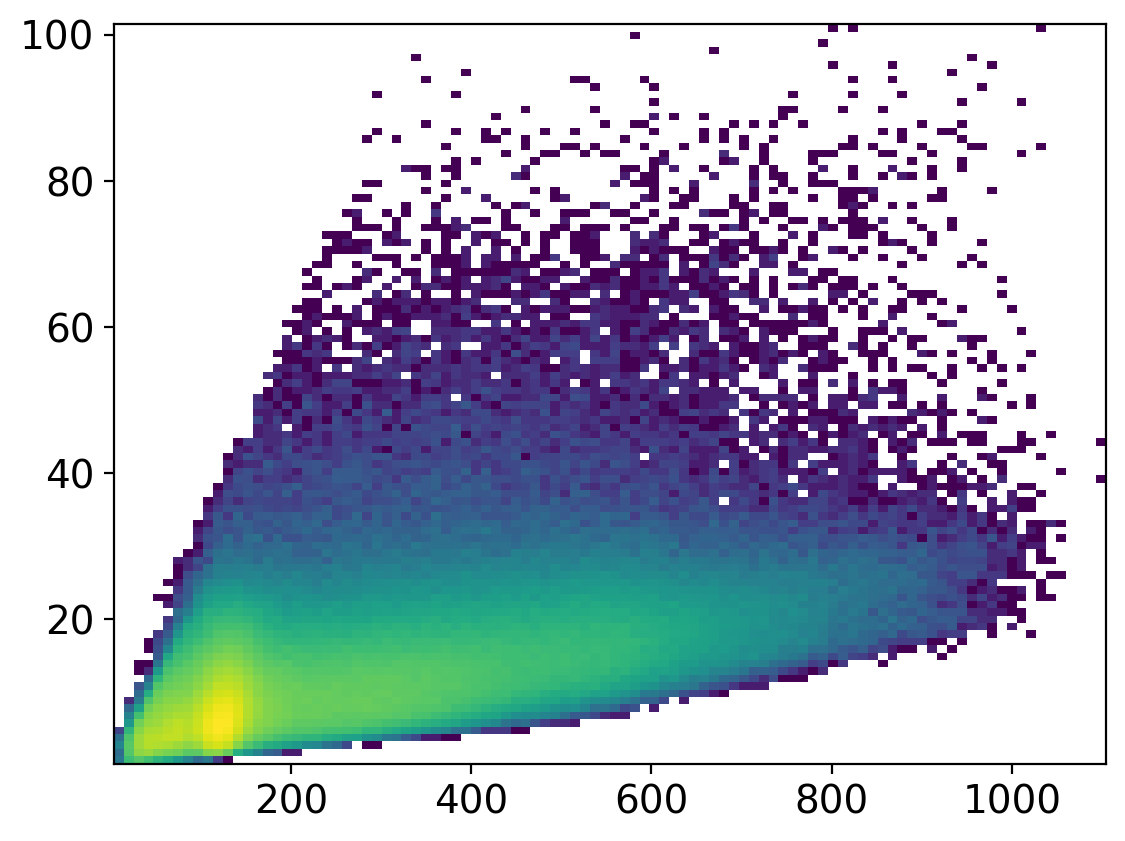

In [119]:
plt.hist2d(lum_pseu, elum_pseu, bins=100, norm=colors.LogNorm());

In [120]:
scaler_plum = preprocessing.RobustScaler(quantile_range=(2.5, 97.5))

norm_plum = scaler_plum.fit_transform(lum_pseu.values.reshape(-1,1))
norm_eplum = elum_pseu.values.reshape(-1, 1) / scaler_plum.scale_


joblib.dump(scaler_plum, '../models/scaler_plum.gz')

['../models/scaler_plum.gz']

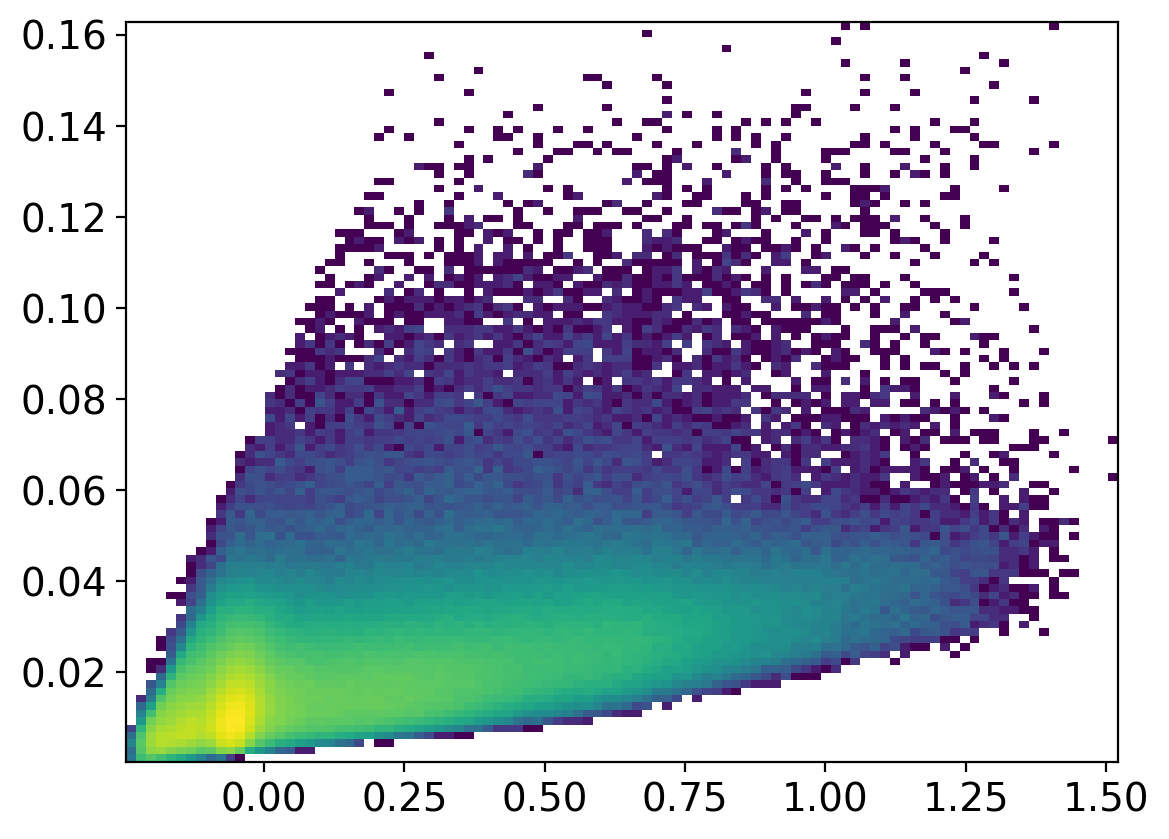

In [121]:
plt.hist2d(norm_plum.flatten(), norm_eplum.flatten(), bins=100, norm=colors.LogNorm());

In [122]:
save_data = {
    "norm_xp":norm_xp, 
    "labels":norm_plum.flatten(), "e_labels":norm_eplum.flatten(),
    "source_id":xp_tr['source_id'].values
}

fname = "xp_pseudolum_737640.npy"
np.save(data_dir+fname, save_data)

# Test by NN model

In [153]:
class GXP_prlx():
    """Gaia DR3 XP continuous spectrum to stellar labels instance
    """
    def __init__(self, data, total_num=6000, part_train=True, device=torch.device('cpu')) -> None:
        
        self.data = np.load(data, allow_pickle=True).item()
        self.xp = self.data['norm_xp']
        self.labels = self.data['labels']
        self.e_labels = self.data['e_labels']
        self.source_id = self.data['source_id']
        self.total_num = total_num
        self.part_train = part_train
        self.device = device
    
    def __len__(self) -> int:
        if self.part_train:
            num_sets = self.total_num
        else:
            num_sets = len(self.labels)
        return num_sets

    def __getitem__(self, idx: int):
        x = torch.tensor(self.xp[idx].astype(np.float32)).to(self.device)
        y = torch.tensor(self.labels[idx].astype(np.float32)).to(self.device)
        e_y = torch.tensor(self.e_labels[idx].astype(np.float32)).to(self.device)
        
        return {'x':x, 'y':y, 'e_y':e_y, 'id':self.source_id[idx]}

    
def recover_scale_label(y_hat, e_y_hat=None):
    
    scaler_labels = joblib.load('../models/scaler_plum.gz')
    
    y   = scaler_labels.inverse_transform(y_hat)
    
    if e_y_hat is not None:
        e_y = e_y_hat * scaler_labels.scale_
        return y, e_y
    else:
        return y
    
    
def infer_4lbs_model(model_name, data_loader, transcale_method=recover_scale_label,
                     model_type='nn',
                     n_input=110, n_output=1, n_dim=8, 
                     n_head=8, n_layer=2, device=torch.device('cuda:0')):
    
    if model_type == 'attn':
        model = xp2label_attn(n_encoder_inputs=n_input, n_outputs=n_output,).to(device)
    elif model_type == 'nn':
        model = xp2label_nn(n_encoder_inputs=n_input, n_outputs=n_output, channels=n_dim).to(device)
    
    model.load_state_dict(torch.load(model_name))
    
    out_lst, e_out_lst = np.array([]), np.array([])
    id_lst = []

    with torch.no_grad():
        
        for data in tqdm(data_loader):
            output = model(data['x'])
            out_lst   = np.append(out_lst,  output.cpu().numpy())
            id_batch =  list(np.int64(data['id']))
            
            del output, data
            for idl in id_batch:
                id_lst.append(idl)

    out_lst = np.array(out_lst).reshape(-1,n_output)
    y, e_y = transcale_method(out_lst, out_lst)
    return {'labels':y, 'source_id':id_lst}



In [148]:
%load_ext autoreload
%autoreload 2

from kvxp.kvxp import xp2label_nn, xp2label_attn
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, SubsetRandomSampler

# from kvxp.data import GXP_prlx


tr_file = "xp_pseudolum_737640.npy"
device = torch.device('cuda:0')
TOTAL_NUM = int(5e4)
BATCH_SIZE = 2**12
num_epochs = 500
part_train = True

"""model params
"""
INPUT_LEN = 110
n_outputs = 1
n_dim = 8
n_head = 2
n_layer = 2

model_dir = "/data/jdli/gaia/model/0202_prlx/"

xpdata  = GXP_prlx(
        data_dir+tr_file, part_train=True, 
        total_num=TOTAL_NUM, device=device
)

k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [169]:
model = xp2label_nn(
    n_encoder_inputs=INPUT_LEN, 
    n_outputs=n_outputs, channels=n_dim,
).to(device)

model_name = "sp2_ap_prlx_0_ep100.pt"
pred_names = ['psu_lum_nn']
rdf_tot = pd.DataFrame()

for fold, (train_ids, valid_ids) in enumerate(kfold.split(xpdata)):
    
        print(f'FOLD {fold}')
        print('--------------------------------')

        if fold==0:

            train_subsampler = SubsetRandomSampler(train_ids)
            valid_subsampler = SubsetRandomSampler(valid_ids)
            
            tr_loader = DataLoader(xpdata, batch_size=BATCH_SIZE, sampler=train_subsampler)
            val_loader = DataLoader(xpdata, batch_size=BATCH_SIZE, sampler=valid_subsampler)
            
            labels_infer = infer_4lbs_model(
                model_dir+model_name, tr_loader, device=device, 
                model_type='nn',
                transcale_method=recover_scale_label
             )

            rdf = pd.DataFrame(labels_infer['labels'], columns=pred_names)
            rdf = rdf.assign(source_id=labels_infer['source_id'])
            rdf_tot = pd.concat([rdf_tot, rdf], ignore_index=True)

            print(len(rdf_tot))
            
            
rdf_tot = rdf_tot.merge(xp_tr[['source_id', 'lum_pseu', 'e_lum_pseu']])

FOLD 0
--------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.58it/s]

40000
FOLD 1
--------------------------------
FOLD 2
--------------------------------
FOLD 3
--------------------------------
FOLD 4
--------------------------------


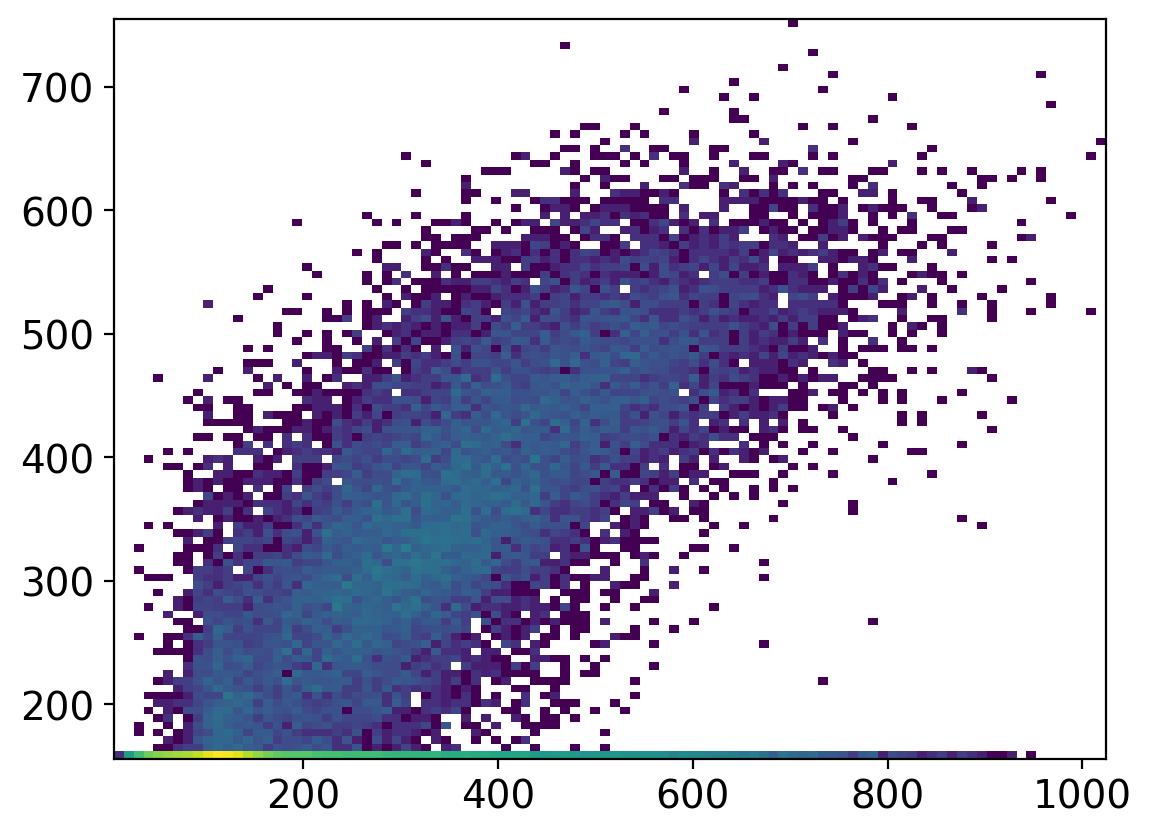

In [171]:
plt.hist2d(rdf_tot['lum_pseu'], rdf_tot['psu_lum_nn'], 
           norm=colors.LogNorm(), bins=100);

In [173]:
def rmse(res):
    return np.sqrt(np.nanmean(res**2))

rmse(rdf_tot['lum_pseu']-rdf_tot['psu_lum_nn'])/scaler_plum.scale_

array([0.19597458])

In [177]:
model.load_state_dict(torch.load(model_dir+model_name))
    
out_lst, e_out_lst = np.array([]), np.array([])
y_lst = np.array([])
id_lst = []

with torch.no_grad():

    for data in tqdm(val_loader):
        output = model(data['x'])
        gt = data['y'].cpu().numpy()
        out_lst   = np.append(out_lst, output.cpu().numpy())
        y_lst = np.append(y_lst, gt)
        id_batch =  list(np.int64(data['id']))

        del output, data
        for idl in id_batch:
            id_lst.append(idl)

out_lst = np.array(out_lst).reshape(-1,n_output)
# y, e_y = transcale_method(out_lst, out_lst)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.25it/s]


NameError: name 'n_output' is not defined

In [178]:
out_lst

array([0.       , 0.       , 0.       , ..., 0.       , 0.2781747,
       0.       ])

In [179]:
y_lst

array([-0.06584609, -0.03249336,  0.27309614, ..., -0.12385324,
        0.18705837,  0.15417473])

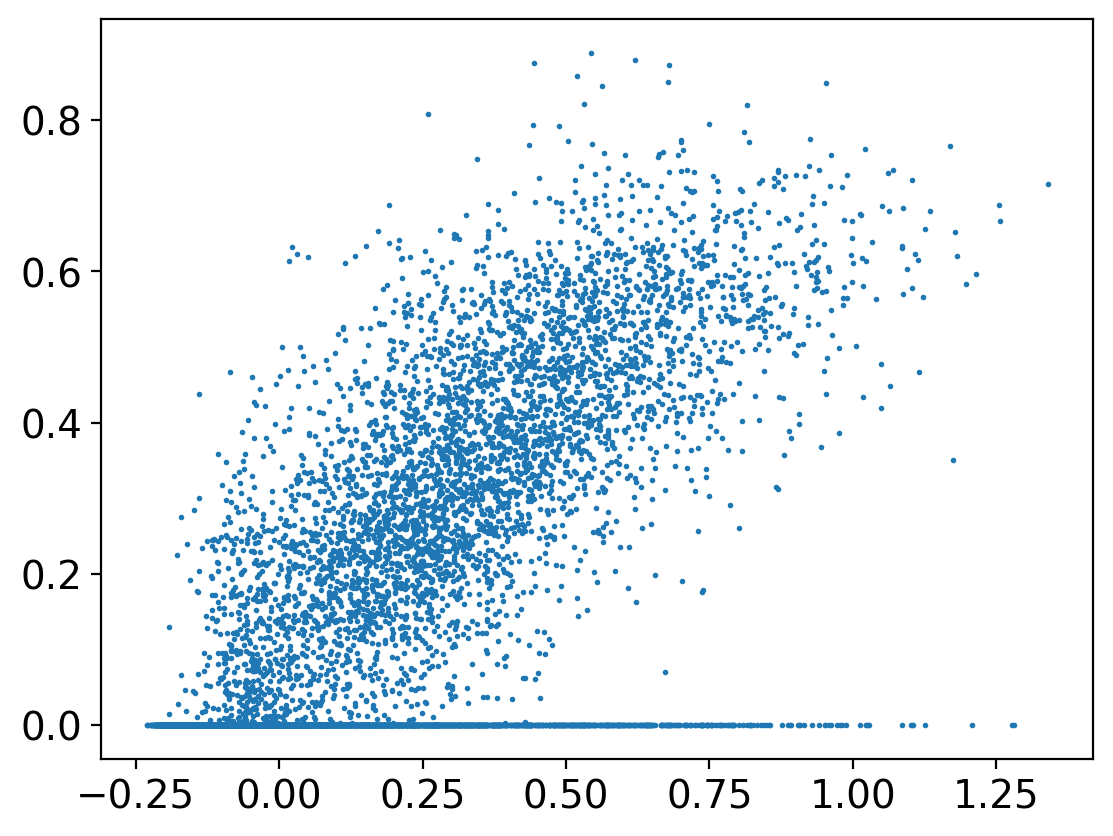

In [181]:
plt.scatter(y_lst, out_lst, s=1)